In [1]:
# import the data and save 
import yfinance as yf   

data1 = yf.download('INFY.NS','2010-01-01','2018-01-01') 
data1.to_csv('InfosysStockPrice.csv')
# data1

[*********************100%***********************]  1 of 1 completed


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import math
import pywt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

,Close
Date,
2010-01-04,326.575012
2010-01-05,327.668762
2010-01-06,322.887512
2010-01-07,315.631256
2010-01-08,308.024994
...,...
2017-12-22,519.674988
2017-12-26,517.799988
2017-12-27,517.125000


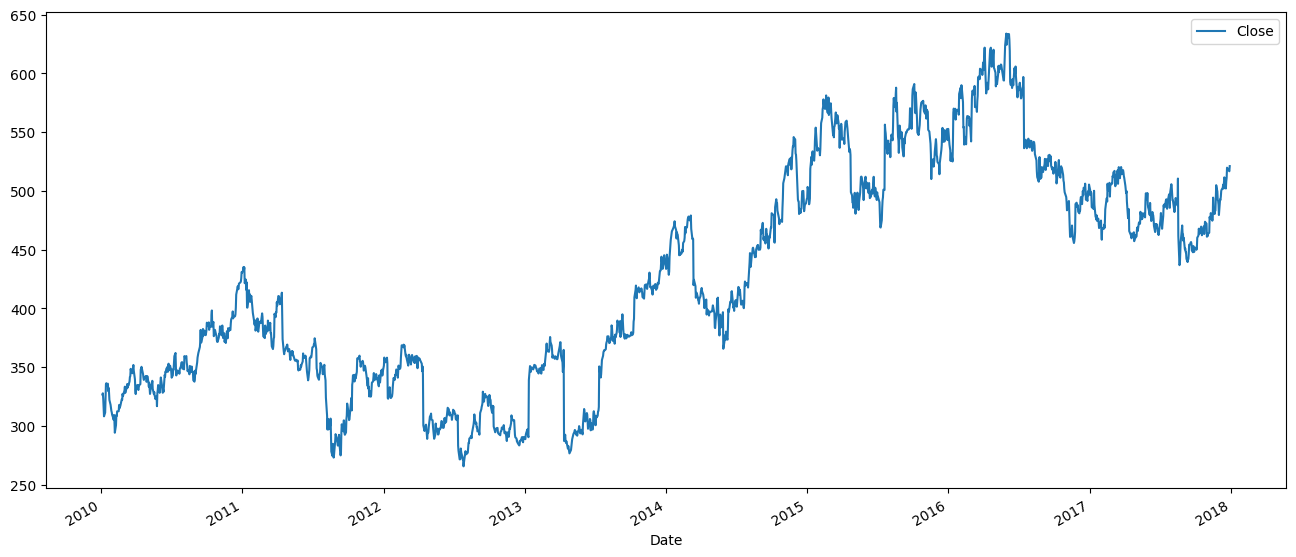

In [82]:
# plotting data

df = pd.read_csv('InfosysStockPrice.csv', index_col = 'Date', parse_dates = True)
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

df = df.dropna()
df['Close'].plot(figsize = (16, 7), legend= True)
df

In [114]:
# from sklearn.preprocessing import MinMaxScaler # if scale first
# scaler = MinMaxScaler(feature_range=(0,1))

# scaled_data = scaler.fit_transform(np.array(df))
# len(scaled_data)
# # normalized_train

1973

[323.5443907  325.34747641 326.57659406 ... 517.0387113  517.93131351
 518.73148218]


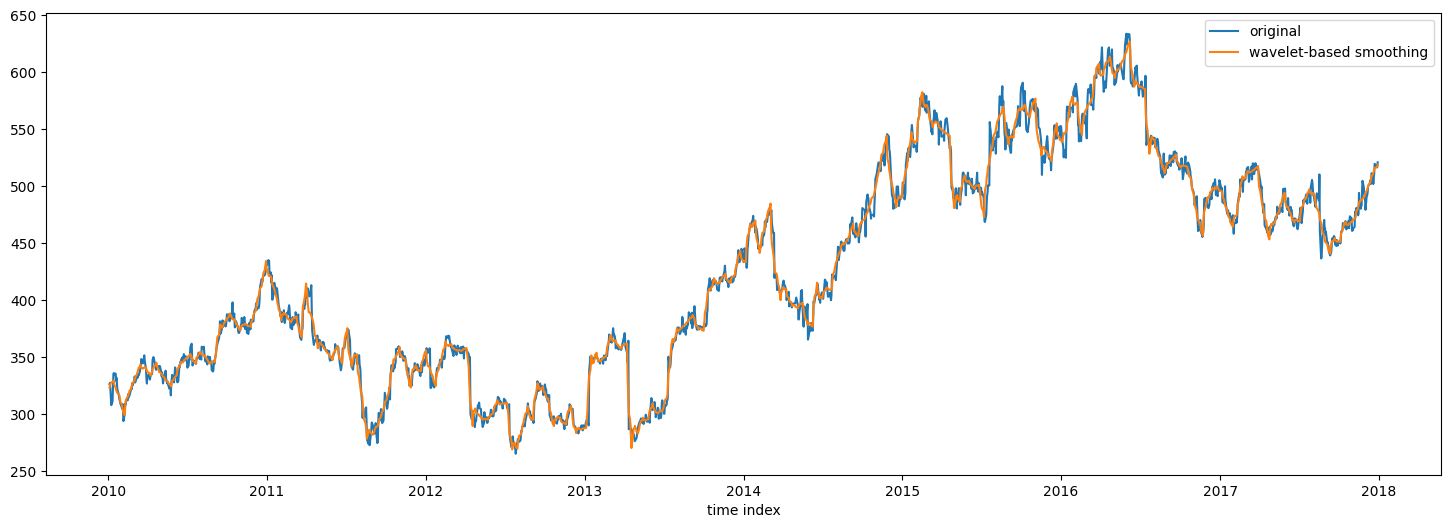

In [83]:
# Smoothening the time series

x = df.index
y = df['Close'] # if smoothen/wavelet first
# y = scaled_data # if scale first
# y = np.reshape(y, (y.shape[0])) 
# print(x.shape)
# print(y.shape)

coeffs = pywt.wavedec(y, 'db2', mode='symmetric', level = 3)
for i in range(1, 4):
    coeffs[i] = np.zeros(coeffs[i].shape)
    
# reconstruct wavelet
y_rec = pywt.waverec(coeffs, 'db2', mode='symmetric')[1:]
print(y_rec)

plt.figure(figsize=(18,6))
plt.plot(x, y)
plt.plot(x, y_rec)
plt.legend(['original', 'wavelet-based smoothing'])
plt.xlabel('time index')
plt.show()


In [5]:
# Reshape smoothened series

y_rec = np.reshape(y_rec, (y_rec.shape[0], 1))
print(y_rec.shape)

(1973, 1)


In [8]:
# Scaling all the values between 0 to 1

# from sklearn.preprocessing import MinMaxScaler # if smoothen/wavelet first
scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(np.array(y_rec))
len(scaled_data)

1973

In [9]:
scaled_data

array([[0.15164566],
       [0.15668707],
       [0.16012366],
       ...,
       [0.69265336],
       [0.69514906],
       [0.69738632]])

In [173]:
# if scaled first :
# tmp = scaler.inverse_transform(y_rec)
# print(tmp)
# # print(y_rec)

[[323.5443907 ]
 [325.34747641]
 [326.57659406]
 ...
 [517.0387113 ]
 [517.93131351]
 [518.73148218]]


In [10]:
# Divide data into train and test

# dataset = df.values
# dataset = tmp # if scaled first
dataset = y_rec # if smoothen first
# type(dataset)
train_len = int(len(dataset) * 0.7)
train_data = scaled_data[0:train_len, :]
# train_data = y_rec[0:train_len, :]
len(train_data)

1381

In [58]:
time_steps = 20

In [84]:
# Get x_train and y_train from training data 

x_train = []
y_train = []

for i in range(time_steps, train_len):
    x_train.append(train_data[i-time_steps:i, 0])
    y_train.append(train_data[i, 0])
    if i <= (time_steps+1):
        print((x_train), "\n")
        print((y_train), "\n")



[array([0.15164566, 0.15668707, 0.16012366, 0.16195545, 0.16421725,
       0.16487424, 0.16596124, 0.16747824, 0.16888002, 0.15864903,
       0.15153503, 0.14753802, 0.14270582, 0.14099061, 0.1384402 ,
       0.1350546 , 0.13189279, 0.12322909, 0.11603962, 0.11032437])] 

[0.10421410533959152] 

[array([0.15164566, 0.15668707, 0.16012366, 0.16195545, 0.16421725,
       0.16487424, 0.16596124, 0.16747824, 0.16888002, 0.15864903,
       0.15153503, 0.14753802, 0.14270582, 0.14099061, 0.1384402 ,
       0.1350546 , 0.13189279, 0.12322909, 0.11603962, 0.11032437]), array([0.15668707, 0.16012366, 0.16195545, 0.16421725, 0.16487424,
       0.16596124, 0.16747824, 0.16888002, 0.15864903, 0.15153503,
       0.14753802, 0.14270582, 0.14099061, 0.1384402 , 0.1350546 ,
       0.13189279, 0.12322909, 0.11603962, 0.11032437, 0.10421411])] 

[0.10421410533959152, 0.09957806748684206] 



In [60]:
# convert to numpy array

x_train = np.array(x_train)
y_train = np.array(y_train)
len(x_train)

1361

In [61]:
# reshape to required form
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # 1 means closing price
x_train.shape

(1361, 20, 1)

In [323]:
# # Lyapunov exponent

# from math import log
# import numpy as np

# with open('data1.txt', 'r') as f:
#     data = [float(i) for i in f.read().split()]

# N = len(data)
# eps = 0.001
# lyapunovs = [[] for i in range(N)]

# for i in range(N):
#     for j in range(i + 1, N):
#         if np.abs(data[i] - data[j]) < eps:
#             for k in range(min(N - i, N - j)):
#                 if(np.abs(data[i+k] - data[j+k]) == 0):
#                     continue
#                 lyapunovs[k].append(log(np.abs(data[i+k] - data[j+k])))

# with open('lyapunov.txt', 'w') as f:
#     for i in range(len(lyapunovs)):
#         if len(lyapunovs[i]):
#             string = str((i, sum(lyapunovs[i]) / len(lyapunovs[i])))
#             f.write(string + ' \n')


In [47]:
# from math import log
 
# def d(series,i,j):
#     return abs(series[i]-series[j])
 
# f=open('data1.txt', 'r')
# series=[float(i) for i in f.read().split()]
# f.close()
# N=len(series)
# eps=float(input('Initial diameter bound: '))
# dlist=[[] for i in range(N)]
# n=0 #number of nearby pairs found
# for i in range(N):
#     for j in range(i+1,N):
#         if d(series,i,j) < eps:
#             n+=1
#             print(n)
#             for k in range(min(N-i,N-j)):
#                 if(d(series,i+k,j+k) == 0):
#                     continue
#                 dlist[k].append(log(np.abs(d(series,i+k,j+k))))
# f=open('lyapunov1.txt','w')
# for i in range(len(dlist)):
#     if len(dlist[i]):
#         print>>f, i, sum(dlist[i])/len(dlist[i])
# f.close()

Initial diameter bound: 9
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
27

KeyboardInterrupt: 

In [317]:
# File_data = np.loadtxt("data1.txt", dtype=float)
# print(File_data)

[326.25      327.5       335.375     ... 514.        515.
 515.0499878]


In [320]:
# def lyapunov_exponent(series: np.array, threshold: float):
    
#     N = len(series)
#     eps = threshold
    
#     L = [np.array([0]*N)]
#     for i in range(1, N):
#         diff = np.abs(series[i:]-series[:-i])
#         dist = np.log(diff)
#         L.append(np.concatenate([[0]*i, dist]))
#     L = np.array(L)
    
#     tf_L = np.where(L<eps, 1, 0)
#     count_L = np.zeros_like(tf_L)
    
#     for i in range(N):
#         indices = ( np.array(range(0,N-i)), np.array(range(i,N)) )
#         count_L[indices] = np.cumsum(tf_L[indices])
    
#     avg = np.sum(count_L * L, axis=0) / np.sum(count_L, axis=0)
    
#     return avg


In [322]:
# ans = lyapunov_exponent(File_data, 0.01)

C:\Users\smrut\AppData\Local\Temp\ipykernel_14240\3755689492.py:9: RuntimeWarning: divide by zero encountered in log
  dist = np.log(diff)


array([0.        , 0.11157178, 1.42490369, ..., 4.40125403,       -inf,
       4.3878817 ])

In [62]:
# Build LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [64]:
# compile
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [65]:
# train model
model.fit(x_train, y_train, batch_size = 8, epochs = 20)

Epoch 1/20
171/171 [==============================] - 7s 14ms/step - loss: 0.0073
Epoch 2/20
171/171 [==============================] - 3s 15ms/step - loss: 0.0016
Epoch 3/20
171/171 [==============================] - 2s 14ms/step - loss: 0.0015
Epoch 4/20
171/171 [==============================] - 2s 14ms/step - loss: 7.4124e-04
Epoch 5/20
171/171 [==============================] - 3s 15ms/step - loss: 6.2295e-04
Epoch 6/20
171/171 [==============================] - 2s 14ms/step - loss: 6.1921e-04
Epoch 7/20
171/171 [==============================] - 2s 14ms/step - loss: 4.1175e-04
Epoch 8/20
171/171 [==============================] - 3s 15ms/step - loss: 3.7909e-04
Epoch 9/20
171/171 [==============================] - 3s 15ms/step - loss: 3.4365e-04
Epoch 10/20
171/171 [==============================] - 2s 14ms/step - loss: 3.4823e-04
Epoch 11/20
171/171 [==============================] - 2s 13ms/step - loss: 2.3822e-04
Epoch 12/20
171/171 [==============================] - 2s 14ms/s

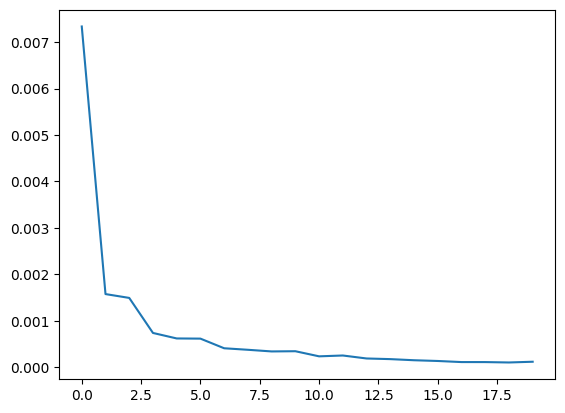

In [66]:
# plotting loss

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [67]:
# Getting test data

test_data = scaled_data[train_len - time_steps :, :]
# test_data = y_rec[train_len - time_steps :, :] # if 

x_test = []
y_test = dataset[train_len :, :]

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0])
x_test

[array([0.60865683, 0.6352845 , 0.64948059, 0.66700771, 0.67210324,
        0.6805298 , 0.6922874 , 0.70315245, 0.70908473, 0.71633874,
        0.72491448, 0.73313606, 0.74267938, 0.75186854, 0.76070354,
        0.76963344, 0.77254501, 0.77706918, 0.78320596, 0.78891065]),
 array([0.6352845 , 0.64948059, 0.66700771, 0.67210324, 0.6805298 ,
        0.6922874 , 0.70315245, 0.70908473, 0.71633874, 0.72491448,
        0.73313606, 0.74267938, 0.75186854, 0.76070354, 0.76963344,
        0.77254501, 0.77706918, 0.78320596, 0.78891065, 0.79622794]),
 array([0.64948059, 0.66700771, 0.67210324, 0.6805298 , 0.6922874 ,
        0.70315245, 0.70908473, 0.71633874, 0.72491448, 0.73313606,
        0.74267938, 0.75186854, 0.76070354, 0.76963344, 0.77254501,
        0.77706918, 0.78320596, 0.78891065, 0.79622794, 0.80311313]),
 array([0.66700771, 0.67210324, 0.6805298 , 0.6922874 , 0.70315245,
        0.70908473, 0.71633874, 0.72491448, 0.73313606, 0.74267938,
        0.75186854, 0.76070354, 0.76963344

In [68]:
# reshape

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [69]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

19/19 [==============================] - 1s 7ms/step


In [158]:
# print(predictions)

[[556.4779 ]
 [559.26984]
 [561.87726]
 [564.1246 ]
 [566.366  ]
 [565.861  ]
 [565.5636 ]
 [566.8983 ]
 [568.4169 ]
 [570.3282 ]
 [572.0232 ]
 [573.30927]
 [574.59247]
 [563.41156]
 [553.21765]
 [550.16473]
 [547.802  ]
 [547.13416]
 [545.59186]
 [542.3136 ]
 [538.9632 ]
 [543.89716]
 [548.77356]
 [549.2119 ]
 [548.8937 ]
 [547.4113 ]
 [546.558  ]
 [546.88464]
 [547.2558 ]
 [554.58435]
 [561.5092 ]
 [564.2618 ]
 [566.3837 ]
 [567.44086]
 [569.08   ]
 [571.80786]
 [574.5506 ]
 [572.3944 ]
 [570.43207]
 [571.127  ]
 [572.10535]
 [573.7    ]
 [574.94507]
 [575.5474 ]
 [576.16364]
 [571.86523]
 [568.0303 ]
 [567.10803]
 [566.4565 ]
 [566.49994]
 [566.1783 ]
 [565.14825]
 [564.1131 ]
 [569.737  ]
 [575.0362 ]
 [576.6291 ]
 [577.7876 ]
 [578.0523 ]
 [578.8269 ]
 [580.52783]
 [582.2089 ]
 [566.29974]
 [551.77637]
 [547.0846 ]
 [543.2261 ]
 [541.6538 ]
 [538.92004]
 [533.8516 ]
 [528.67645]
 [534.3622 ]
 [540.1023 ]
 [540.0845 ]
 [538.96716]
 [536.2738 ]
 [534.4081 ]
 [534.12317]
 [533.9394 ]

In [70]:
# Evaluate model : RMSE
rmse = np.sqrt(np.mean((predictions-y_test)**2))
rmse

2.565445233193457

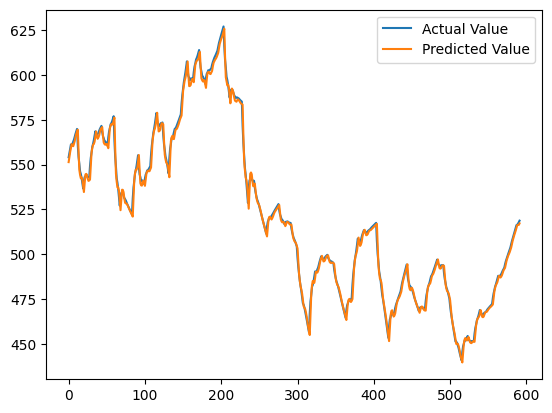

In [71]:
plt.plot(y_test, label = 'Actual Value')
plt.plot(predictions, label = 'Predicted Value')
plt.legend()


In [72]:
# type(y_rec)

df1 = df.copy()
df1['y_rec'] = y_rec # if smoothen first
# df1['tmp'] = tmp
df1 = df1.drop(['Close'], axis=1)
df1

,y_rec
Date,
2010-01-04,323.544391
2010-01-05,325.347476
2010-01-06,326.576594
2010-01-07,327.231744
2010-01-08,328.040688
...,...
2017-12-22,516.288407
2017-12-26,516.491076
2017-12-27,517.038711


C:\Users\smrut\AppData\Local\Temp\ipykernel_10668\1614228976.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


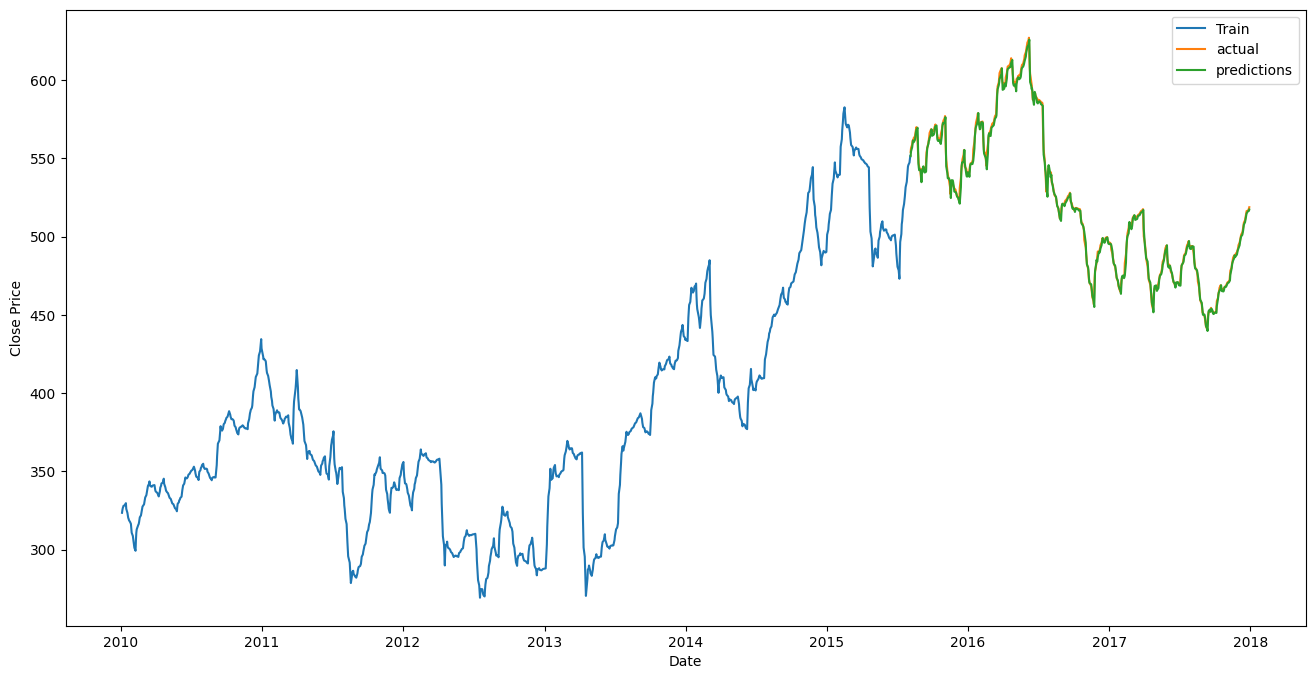

In [73]:
# plot train, test and predicted

# train = df[:train_len]
# test = df[train_len:]
train = df1[:train_len]
test = df1[train_len:]
test['Predictions'] = predictions

plt.figure(figsize = (16, 8))
plt.xlabel('Date')
plt.ylabel('Close Price')
# plt.plot(train['Close'])
# plt.plot(test[['Close', 'Predictions']])
# plt.plot(train['tmp'])
# plt.plot(test[['tmp', 'Predictions']])
plt.plot(train['y_rec'])
plt.plot(test[['y_rec', 'Predictions']])
plt.legend(['Train', 'actual', 'predictions'], loc='best')
plt.show()

In [74]:
from datetime import datetime, timedelta
import datetime as dt
newdf1 = df1.copy()
# newdf1
# print(predictions)
predictions_copy = np.copy(predictions)
predictions_copy = np.reshape(predictions_copy, (predictions_copy.shape[0],))
# print(len(predictions_copy))
# newdf1.iloc[:-len(predictions_copy)].append(pd.DataFrame({'y_rec': predictions_copy}), ignore_index = True) # change test data to predicted test data
newdf1.iloc[-len(predictions_copy):] = np.array(predictions_copy)[:, None]

newdf1.tail(10)
# print((predictions_copy))

,y_rec
Date,
2017-12-15,507.587921
2017-12-18,509.132782
2017-12-19,510.576782
2017-12-20,511.882965
2017-12-21,513.252563
2017-12-22,514.748779
2017-12-26,516.276306
2017-12-27,516.300232
2017-12-28,516.367981


In [75]:
#  newdf
actualprice = yf.download('INFY.NS','2018-01-02','2018-12-31') 
actualprice = actualprice.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
actualprice.shape

[*********************100%***********************]  1 of 1 completed


(244, 1)

In [257]:
actualprice['Close']

Date
2018-01-02    514.849976
2018-01-03    510.649994
2018-01-04    507.700012
2018-01-05    506.000000
2018-01-08    518.025024
2018-01-09    520.674988
2018-01-10    526.125000
2018-01-11    537.900024
2018-01-12    539.224976
2018-01-15    540.575012
2018-01-16    561.424988
2018-01-17    576.049988
2018-01-18    576.349976
2018-01-19    571.724976
2018-01-22    575.000000
2018-01-23    588.549988
2018-01-24    592.900024
2018-01-25    587.700012
2018-01-29    591.450012
2018-01-30    585.325012
Name: Close, dtype: float64

In [76]:
# predict for 1 year using single step prediction

predicted_value = []
newlist = []
window = newdf1[-time_steps:].values # last time_steps days

# print(tmp.shape)
# print(type(window[0]))
for i in range(0, 244):    
    window_scaled = scaler.transform(window)
#     print(type(window))
    X_test = []
    X_test.append(window_scaled)
#     X_test.append(window)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#     print(len(X_test[0]))
    pred = model.predict(X_test)
    pred = scaler.inverse_transform(pred)
    predicted_value.append(pred[0])
    
    list1 = [actualprice['Close'][i]]
    newlist.append(list1)
    
    window = newdf1[-(time_steps-i-1):].values
#     window = np.concatenate((window, predicted_value))
#     print(type(actualprice['Close'][i]))
    window = np.concatenate((window, newlist))
#     print(len(window))
#     print(len(predicted_value))
#     print(X_test)

    


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 183ms/step


In [77]:
# newdf1.tail(14)
np.array(predicted_value)
actualprice['pred'] = predicted_value
actualprice

,Close,pred
Date,,
2018-01-02,514.849976,[516.2995]
2018-01-03,510.649994,[513.8062]
2018-01-04,507.700012,[508.3069]
2018-01-05,506.000000,[504.349]
2018-01-08,518.025024,[503.17725]
...,...,...
2018-12-21,646.200012,[659.60205]
2018-12-24,649.000000,[638.865]
2018-12-26,644.049988,[643.5171]


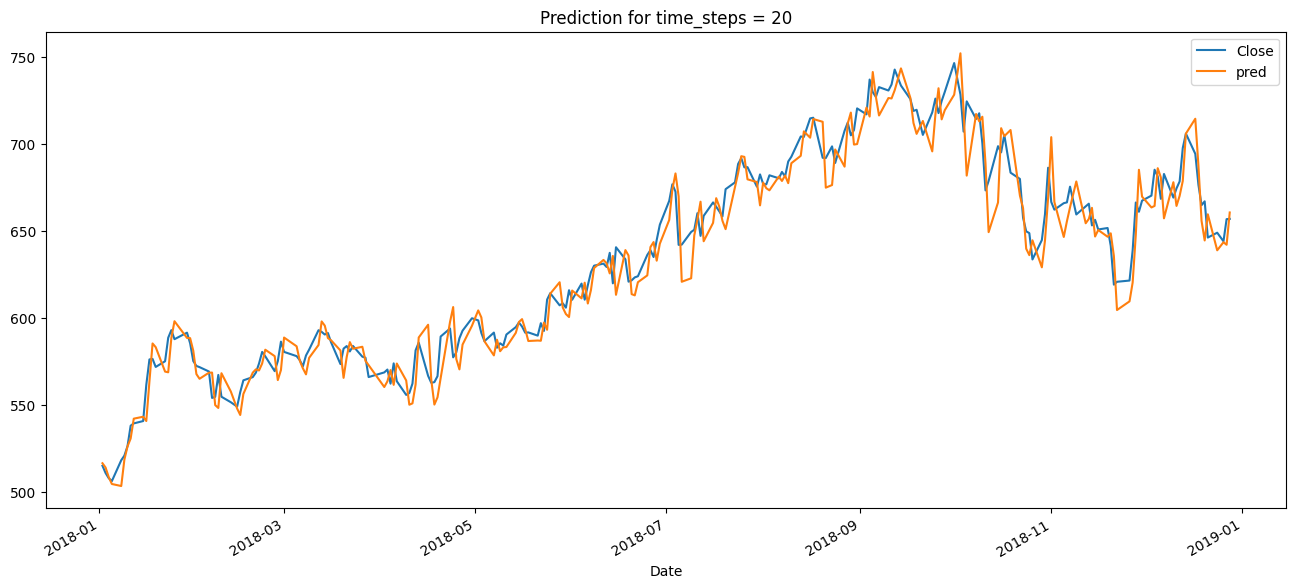

In [78]:
# plot actual and predicted

actualprice['pred'] = actualprice['pred'].astype(float)
# actualprice['pred']
actualprice['Close'].plot(figsize = (16, 7), legend = True)
actualprice['pred'].plot(figsize = (16, 7), legend = True)
plt.title("Prediction for time_steps = %d" %time_steps)
plt.show()


In [79]:
# Rmse
rmse = np.sqrt(np.mean((predicted_value-np.array(actualprice['Close']))**2))
rmse

81.54781121802748

In [203]:
# import the data and save 
import yfinance as yf   

google = yf.download('GOOGL','2010-01-01','2018-01-01') 
google = google.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
apple = yf.download('AAPL', '2010-01-01', '2018-01-01')
apple = apple.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)


# data1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<AxesSubplot: xlabel='Date'>

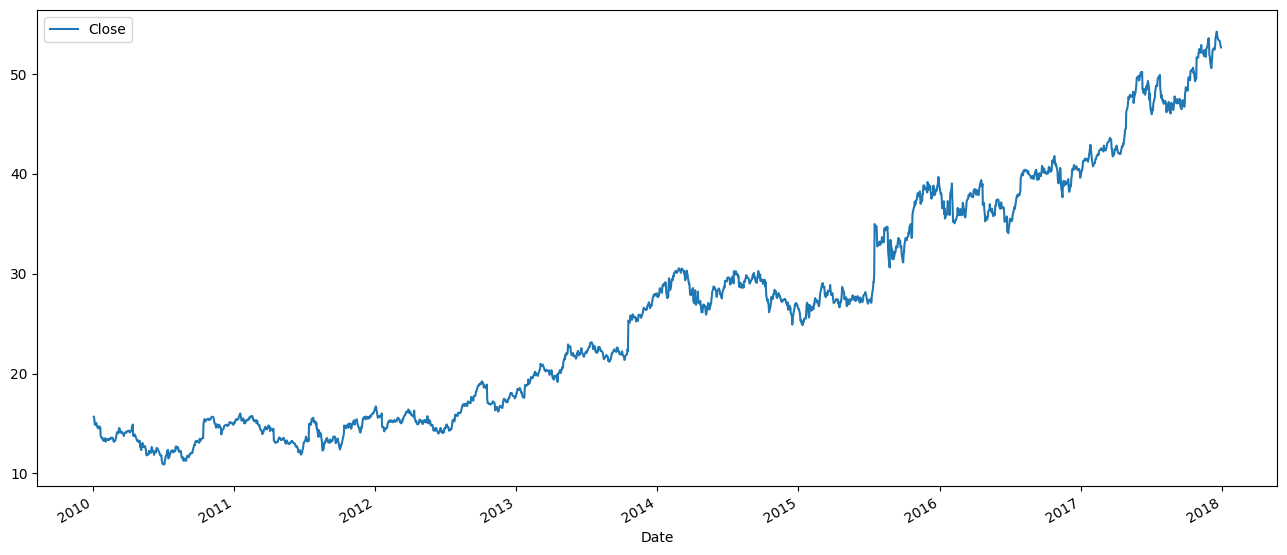

In [198]:
google.head()
google['Close'].plot(figsize = (16, 7), legend= True)

In [205]:
google = google.reset_index(drop=True)
google.to_csv('google.csv')

In [206]:
google

,Close
0,15.684434
1,15.615365
2,15.221722
3,14.867367
4,15.065566
...,...
2008,53.443001
2009,53.292500
2010,53.009998
2011,52.797501


<AxesSubplot: xlabel='Date'>

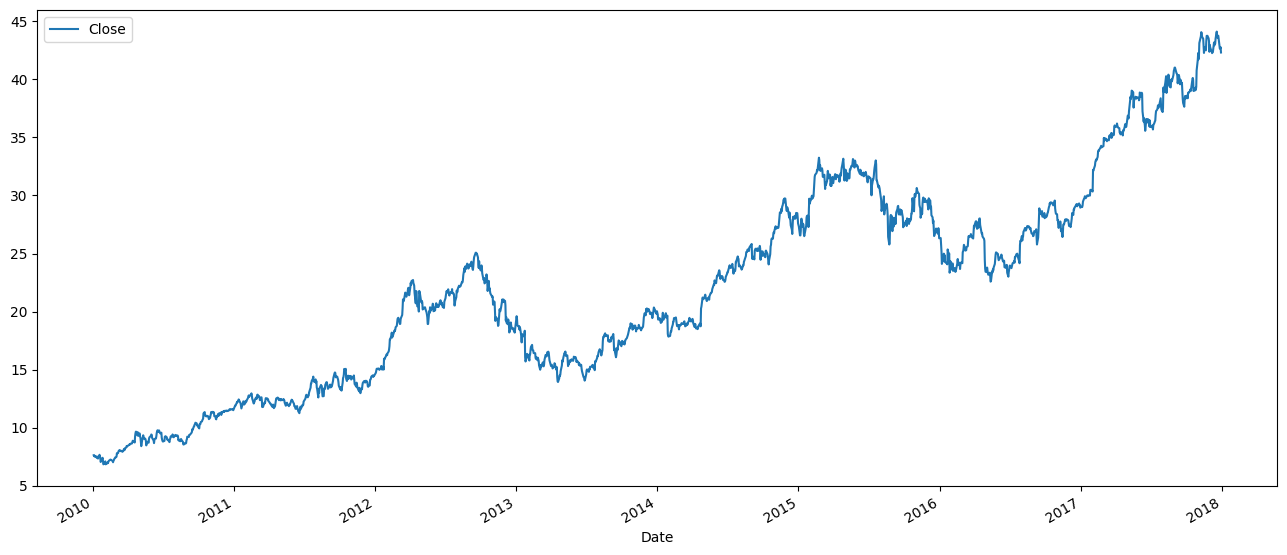

In [207]:
apple['Close'].plot(figsize = (16, 7), legend= True)

In [208]:
apple = apple.reset_index(drop=True)
apple.to_csv('apple.csv')

In [211]:
infosys_chaotic = yf.download('INFY.NS', '2019-01-01', '2023-01-01')
infosys_chaotic = infosys_chaotic.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)


[*********************100%***********************]  1 of 1 completed


<AxesSubplot: xlabel='Date'>

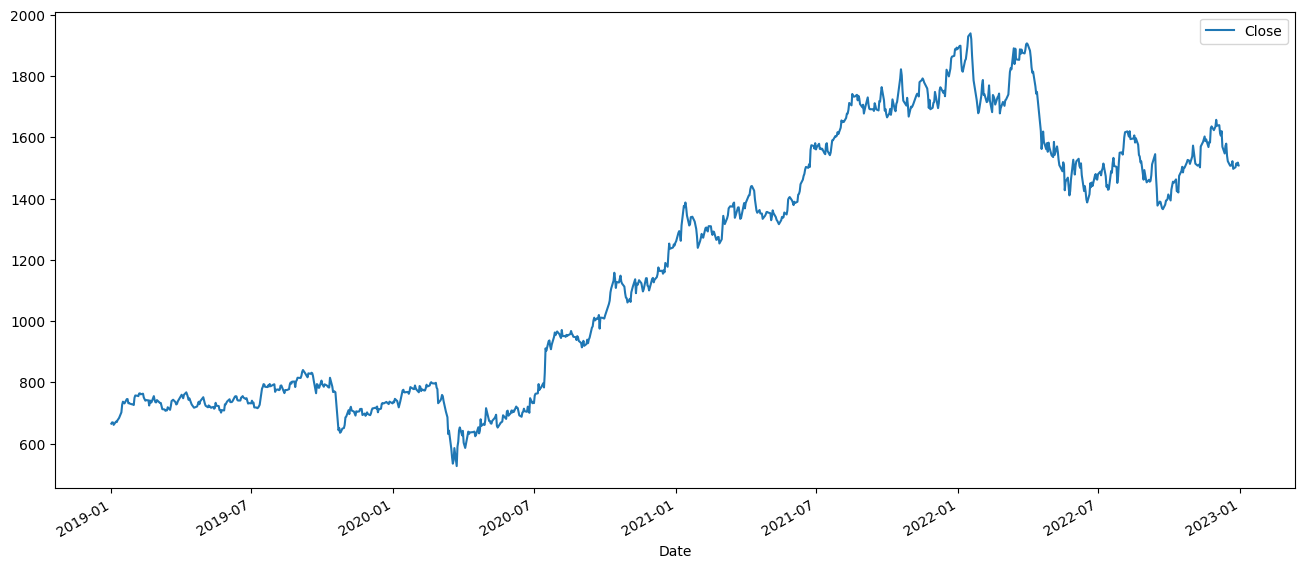

In [212]:
infosys_chaotic['Close'].plot(figsize = (16, 7), legend= True)

In [213]:
infosys_chaotic = infosys_chaotic.reset_index(drop=True)
infosys_chaotic.to_csv('infosys_chaotic.csv')